# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

Adrian Lee, Abu Mazhar, Elliot Kovanda, Gianluca Bianchi

## 0. Setup

In [87]:
# Install required packages
!pip install -q -r requirements.txt

In [88]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import datetime

In [89]:
# Load data
d = pd.read_csv("the_office.csv")
#importing second more up to date dataframe
d2 = pd.read_csv("the_office_series.csv")

## 1. Introduction

This work aims to use information about all past episodes of The Office to determine what distinguishes high-rated episodes from less popular ones. Ultimately, we wish to use this understanding to give advice to NBC Universal Studios on how to create a successful special reunion episode.

First, data was reviewed and cleaned. In particular, we incorporated additional data containing updated and therefore more reliable imdb ratings. We obtained this data from " https://www.kaggle.com/nehaprabhavalkar/the-office-dataset ". Further, this data contained additional information on each episode such as its duration and the presence of guest stars. Importantly, this additional data contains a verbal summary of each episode. By extracting the number of mentions of each character in these descriptions we obtained a proxy for their importance to that episode. We believe this indicator is more granular and superior to the mere character-presence indicator contained in the original data.

Using this combined and cleaned data set we were able to develop several predictive models. These were all trained on a training subset of the 186 episodes. Tuning and evaluation of each model was done using cross-validation to obtain more generalizable error estimates. Ultimately, a shallow decision tree model proved to be most successful as at 0.245 rating points, it had the lowest average, cross-validated prediction error. Using bootstrapping we obtained a tight 95% confidence interval of 0.01 indicating that this result is reliable. We see the simplicity of the model as an asset as it demonstrated high validity does not constrain the producers' creative freedom.

Specifically, we suggest placing Michael at the centre of the reunion episode. Further, episodes that contained more words are generally higher rated. Our analyses therefore suggest to additionally write a show with more than 3447 words, which corresponds to about 13% more than the mean. With these two simple considerations we expect the episode to achieve a rating of 8.9 points. This corresponds to a rating in the 88th percentile.

We believe that this advice is grounded in a robust analysis, feasible to implement and will compliment the producers' domain knowledge and judgements well as it leaves significant room for creative expression.

## 2. Exploratory Data Analysis and Feature Engineering

The `episode_name` and `EpisodeTitle` columns from the two data frames contained spelling errors and discrepancies that would have prevented subsequent merging of the data frames using these columns, including duplicate rows. Therefore these issues were first mitigated through data cleaning.

In [90]:
# data cleaning for episode names

# use lower case
d.episode_name = d.episode_name.apply(lambda x: x.lower())
d2.EpisodeTitle = d2.EpisodeTitle.apply(lambda x: x.lower())

# unify the spellings in the two data frames
d.episode_name = d.episode_name.str.replace('surveilance', 'surveillance', regex=False)
d.episode_name = d.episode_name.str.replace('cover', 'cover-up', regex=False)
d.episode_name = d.episode_name.str.replace('a.a.r.m', 'a.a.r.m.', regex=False)
d.episode_name = d.episode_name.str.replace(' (parts 1&2)', '', regex=False)
d2.EpisodeTitle = d2.EpisodeTitle.str.replace(': part 1', ' (part 1)', regex=False)
d2.EpisodeTitle = d2.EpisodeTitle.str.replace(': part 2', ' (part 2)', regex=False)
d.episode_name = d.episode_name.str.replace('&', 'and', regex=False)
d.episode_name = d.episode_name.str.replace('s*x', 'sex', regex=False)

# remove the word "the" from episode names
d.episode_name = d.episode_name.str.replace('the ', '', regex=False)
d2.EpisodeTitle = d2.EpisodeTitle.str.replace('the ', '', regex=False)

# merge the `about` column of episodes that contains two parts
d2.loc[d2.EpisodeTitle.str.contains('delivery (part 2)', regex=False),'About'] = ' '.join(d2[d2.EpisodeTitle.str.contains('delivery')]['About'])
d2.loc[d2.EpisodeTitle.str.contains('niagara (part 2)', regex=False),'About'] = ' '.join(d2[d2.EpisodeTitle.str.contains('niagara')]['About'])

# only keep rows for the second part
d2 = d2.loc[~d2.EpisodeTitle.str.contains('delivery (part 1)', regex=False)]
d2 = d2.loc[~d2.EpisodeTitle.str.contains('niagara (part 1)', regex=False)]

# remove "(part 2)" from the episode names
d2.loc[d2.EpisodeTitle.str.contains('delivery (part 2)', regex=False), "EpisodeTitle"] = 'delivery'
d2.loc[d2.EpisodeTitle.str.contains('niagara (part 2)', regex=False), "EpisodeTitle"] = 'niagara'

# check whether there are still differences in episode names
set(d.episode_name.tolist()).symmetric_difference(set(d2.EpisodeTitle.tolist()))

set()

Now that we have clean data, we merge the two data frames using the most up-to-date values for `imdb_rating` and `total_votes`.

In [91]:
# select columns of interest from the supplementary data frame
d2 = d2[["Ratings", "EpisodeTitle", "About", "Viewership", "Duration", "GuestStars", "Director"]]

# replace `imdb_rating` in the original dataframe with `Ratings` from the additional data frame, since the latter has a higher sample size
d.imdb_rating = d['episode_name'].map(d2.set_index('EpisodeTitle')['Ratings'])

# combine the two data frames using episode names
d = pd.merge(d, d2, left_on='episode_name', right_on='EpisodeTitle')

# drop `EpisodeTitle`
d = d.drop('EpisodeTitle', axis = 1)

### Feature Engineering: `n_lines`, `n_directions`, `n_words`, `n_speak_char`, and `duration`

On inspection of the aforementioned variables we saw that they are correlated with one another. This is an issue since if we include all of them we may obtain an unstable linear regression model which would perform suboptimally on test data. In order to control for some of this correlation we introduced new variables, `words_per_line`, `lines_per_minute`, `directions_per_minute`, `words_per_minute` and `speaking_characters_per_minute`. However, in our final model this turned out not to be an issue as the model we used allows for correlated variables without affecting the prediction so we returned to the original definition of these variables instead.

In [92]:
# combine `n_words` and `n_lines` into one feature
d['words_per_line'] = d.n_words/d.n_lines

### Feature Engineering: `air_date`, `month`

To explore whether `imdb_ratings` were associated with the months in which episodes were released, the `air_date` was converted to a "date" format. Afterwards, the months could be extracted from the dates, so that the distributions of `imdb_ratings` for each month could be visualised.

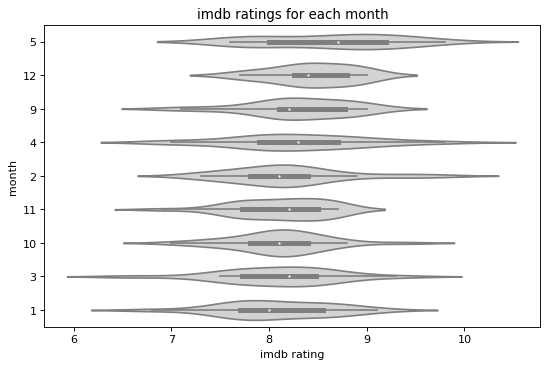

In [93]:
# transform `air_date` into a `date`
d.air_date = pd.to_datetime(d.air_date)

# extract month from `air_date`
d['month'] = pd.DatetimeIndex(d.air_date).month

# imdb ratings for each month
imdb_rating_month = {}

for month in d.month:
    imdb_rating_month[str(month)] = d.imdb_rating[d.month == month].tolist()

imdb_rating_month = pd.DataFrame.from_dict(imdb_rating_month, orient='index').transpose()

# rank violin plot by mean imdb for each `main_char`
months_imdb_ranked = pd.DataFrame({'months': imdb_rating_month.columns,
          'mean_imdb_rating': [mean for mean in np.mean(imdb_rating_month)]}).sort_values(by='mean_imdb_rating', ascending=False)['months'].tolist()

# melt data frame
imdb_rating_month_melted = imdb_rating_month.melt()

# create plot
sns.violinplot(y='variable', x='value', data=imdb_rating_month_melted, color='lightgrey',order=months_imdb_ranked);
plt.title('imdb ratings for each month');
plt.xlabel('imdb rating');
plt.ylabel('month');

### Feature Engineering: `GuestStars` and `main_chars`

The first issue we encountered with these columns was the fact that they were both object types containing strings, which we cannot directly use in our model. Therefore we changed `GuestStar` into a binary variable which simply indicates the presence or absence of a guest star. We chose this as opposed to keeping the original names of the guest stars, since most guest stars only starred in one or two episodes, hence differentiating between them would not be of benefit.

In [94]:
# change GuestStars from names into whether each episode features a guest star (binary: yes/no)
d.loc[pd.notnull(d.GuestStars),"GuestStars"] = 1
d.loc[pd.isnull(d.GuestStars),"GuestStars"] = 0

d.GuestStars = d.GuestStars.astype('int64');

We repeated this process for the `main_char` variable so that each main character now has their own column indicating their presence in each episode.

In [95]:
# split `main_chars` column into multiple columns
main_chars_split = d.main_chars.str.split(expand=True, pat=';')

# find out the total number of episode each main character starred in
main_chars = pd.unique(main_chars_split.values.ravel('K'))
main_chars = main_chars[main_chars != None] # remove Nan's

for char in main_chars:
    d[char] = None
    
# one indicator variable for each `main_char`
for char in main_chars:
    for i in np.arange(0, len(d.main_chars), 1):
        if (char in d.main_chars[i]):
            d.at[i,char] = 1
        else:
            d.at[i,char] = 0

Upon analysis of the number of times each main character appeared in each episode we found that the impact of each appearance on the imdb rating was negligible. This is due to the fact that many of the characters may appeared in an episode but only briefly in comparison to others. In order to differentiate between the impact characters had on the imdb rating futher we considered the `About` column. This contained infomation about the plot and which characters were a key part of a given episode. Our idea was that if we found episodes about particular characters scored noticeably higher or lower than the rest we could be certain that they were integral variables for our model.

The violin plot below shows the imdb rating by character. We can clearly see in the plot that episodes where in which 'Michael' is a key character score bertter than the rest, whilst ones where 'Erin' was mentioned more perform worse.

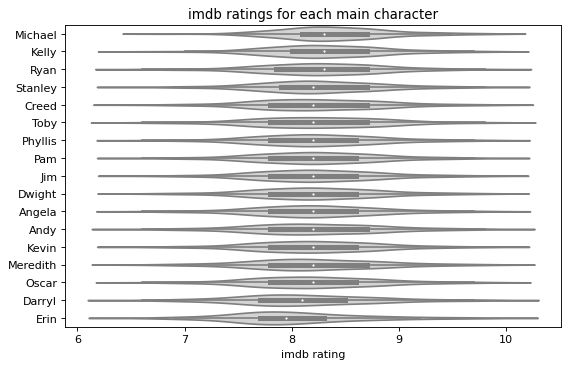

In [96]:
# count no. of occurences of each word in `About`

descriptions = str.split(' '.join(d.About))

descriptions_words_count = {}

# initialise dictionary
for word in descriptions:
    descriptions_words_count[word] = 0 

# count
for word in descriptions:
    descriptions_words_count[word] += 1
    
# count no. of occurences of each `main_chars` in `About`
descriptions_words_count = pd.Series(descriptions_words_count)

# imdb ratings for each main character
imdb_rating_char = {}

for char in main_chars:
    imdb_rating_char[char] = d.imdb_rating[d.main_chars.str.contains(char)].tolist()
imdb_rating_char = pd.DataFrame.from_dict(imdb_rating_char, orient='index').transpose()
# rank violin plot by mean imdb for each `main_char`
main_chars_imdb_ranked = pd.DataFrame({'names': imdb_rating_char.columns,
          'mean_imdb_rating': [mean for mean in np.mean(imdb_rating_char)]}).sort_values(by='mean_imdb_rating', ascending=False)['names'].tolist()

# melt data frame
imdb_rating_char_melted = imdb_rating_char.melt()

# create plot
sns.violinplot(y='variable', x='value', data=imdb_rating_char_melted, color='lightgrey',order=main_chars_imdb_ranked);
plt.title('imdb ratings for each main character');
plt.xlabel('imdb rating');
plt.ylabel('');

We then explored whether there were any statistically significant correlations between the number of mentions of each character in the `About` column with the `imdb_rating`, using the pairplot below. Columns that did not show statistically significant correlations were removed - correlations were deemed statistically significant when no horizontal line could be fit within the 95% convidence interval as indicated by the light blue shading around the regression line. Note that the pairplot below only shows columns with statistically significant correlations due to space constraint. 

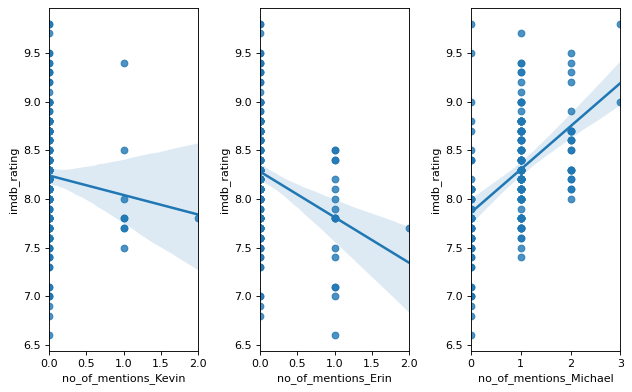

In [109]:
for char in main_chars:
    d[str('no_of_mentions_' + char)] = 0
    
# count the number of occurences of the names of each of the top 5 characters in 'About' 
for i in np.arange(0,len(d.About),1):
    for char in main_chars:
        if char in d.About[i]:
            d.at[i,str('no_of_mentions_' + char)] = d.About[i].count(char)  
#plot creation
fig, axs = plt.subplots(ncols=3)

sns.regplot(x='no_of_mentions_Kevin', y='imdb_rating', data=d, ax=axs[0])
sns.regplot(x='no_of_mentions_Erin', y='imdb_rating', data=d, ax=axs[1])
sns.regplot(x='no_of_mentions_Michael',y='imdb_rating', data=d, ax=axs[2])
fig.tight_layout()
plt.show()

### Feature Engineering: `director` and `writer`

With directors we had an issue that we could not consider each director indivdually, due to the fact that there were so many which would make our model far more complex than it needed to be. On observing the data we found that there were directors who directed several episodes and some which only directed a single episode. In order to use this information to best help with our recommendation to NBC Univeral, whilst still keeping our model simple enough, we chose to split the directors into groups A,B,C and D. These correspond to directors who have written: 1 to 2, 3 to 6, 7 to 13 and 14 to 15 episodes respectively. 

In [76]:
# split `director` column into multiple columns
director_split = d.director.str.split(expand=True, pat=';')

directors = pd.unique(director_split.values.ravel('K'))
directors = directors[directors != None] # remove Nan's

# number of episodes each director took part in
director_count = [director_split[director_split==director].count().sum() for director in directors]
# create data frame with directors' names and number of episodes featured in
director_count = pd.DataFrame({'name': directors, 'count': director_count}).set_index('name')
# sort values
director_count = director_count.sort_values(by='count', ascending=False)

# take an average of episodes directed for episodes with more than one director
director_split_count = director_split

for director in director_count.index.tolist():
    director_split_count[director_split_count == director] = director_count.loc[director,"count"]
    
director_split_avg = np.mean(director_split_count,axis=1).astype('int')


# generate new column for the groups
d['director_grouped'] = 0

d.loc[(director_split_avg >= 1)&(director_split_avg <= 2), 'director_grouped'] = 'A'
d.loc[(director_split_avg >= 3)&(director_split_avg <= 6), 'director_grouped'] = 'B'
d.loc[(director_split_avg >= 7)&(director_split_avg <= 13), 'director_grouped'] = 'C'
d.loc[(director_split_avg >= 14)&(director_split_avg <= 15), 'director_grouped'] = 'D'

We repeated this process with the `writer` column, this time splitting into groups A,B,C,D and E,  respectively correspoding to: 1 to 4, 5 to 9, 10 to 13, 14 to 17 and 18 to 21 episodes written.

In [77]:
# split `writer` column into multiple columns
writer_split = d.writer.str.split(expand=True, pat=';')

writers = pd.unique(writer_split.values.ravel('K'))
writers = writers[writers != None] # remove Nan's

# number of episodes each writer took part in
writer_count = [writer_split[writer_split==writer].count().sum() for writer in writers]
# create data frame with writers' names and number of episodes featured in
writer_count = pd.DataFrame({'name': writers, 'count': writer_count}).set_index('name')
# sort values
writer_count = writer_count.sort_values(by='count', ascending=False)

# take an average of episodes written for episodes with more than one writer
writer_split_count = writer_split

for writer in writer_count.index.tolist():
    writer_split_count[writer_split_count == writer] = writer_count.loc[writer,"count"]
    
writer_split_avg = np.mean(writer_split_count,axis=1).astype('int')


# generate new column for the groups
d['writer_grouped'] = 0

d.loc[(writer_split_avg >= 1)&(writer_split_avg <= 4), 'writer_grouped'] = 'A'
d.loc[(writer_split_avg >= 5)&(writer_split_avg <= 9), 'writer_grouped'] = 'B'
d.loc[(writer_split_avg >= 10)&(writer_split_avg <= 13), 'writer_grouped'] = 'C'
d.loc[(writer_split_avg >= 14)&(writer_split_avg <= 17), 'writer_grouped'] = 'D'
d.loc[(writer_split_avg >= 18)&(writer_split_avg <= 21), 'writer_grouped'] = 'E'

### One-Hot Encoding and Final Inspection of the Data Frame

In [78]:
d = pd.get_dummies(d, columns = ['director_grouped', 'writer_grouped', 'month'])

In [79]:
# only keep columns that are of interest
d = d[['imdb_rating', 'total_votes', 'Viewership', 'Duration', 'GuestStars', 'words_per_line',
       'n_lines', 'n_directions', 'n_words', 'n_speak_char', 
   'no_of_mentions_Kevin', 'no_of_mentions_Erin', 'no_of_mentions_Michael',
   'director_grouped_A', 'director_grouped_B', 'director_grouped_C', 'director_grouped_D',
   'writer_grouped_A', 'writer_grouped_B', 'writer_grouped_C', 'writer_grouped_D', 'writer_grouped_E', 
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 
       'month_9', 'month_10', 'month_11', 'month_12']]

## 3. Model Fitting and Tuning

As an initial step we developed a baseline model that guesses the mean imdb rating on any episode regardless of its characteristics. Clearly this provide no insight into what distinguishes popular episodes from less popular ones. However, it does give us an idea of how good our models should be. Specifically, the naive mean model produces an RMSE of 0.63. We would therefore expect any more complex model to be superior to that.

Indeed, we first explored a linear regression model with all of the initial variables being kept. This produced a cross-validation RMSE of 0.555 which is slightly better than the naive baseline. However, we might improve on this by either adding flexiblity through additional polynomial degrees or reducing flexibility by removing unrelated variables. First, we performed a search over higher degree polynomial models finding that in fact the linear model was best suited. Next, we explored regularisation: With LASSO we aimed to reduce the feature space and indeed after optimising for the tuning parameter $\alpha$ we obtained an improved cross-validation RMSE of 0.519. This is a slight improvement on the full linear model and with only 5 predictors remaining would be easier to interpret and draw conclusions from. We tried ridge regression with similar success (CV RMSE of 0.519). Regularisation helped, however, the model was still quite poor. This was particularly obvious when plotting the fit and the residuals. The predictions were rather flat, overestimating unpopular shows and underestimating popular ones. As a result, we decided to proceed with a Decision Tree Regression model.

We also inverstigated the idea of using a random forest as our predictive model. Whilst this model yielded accurate results (CV RMSE of -0.235, see best score below), we opted not to choose it. This was mainly due to the fact that the results are not very interpertable. While we could make inferences about how important a given feature was to our model, we could not say in which way, either positively or negatively. This made it reduntant in making recommendations. However, our findings in this model and our final regression tree model were similar in that they both deemed the most important feature to improve an episode's rating to be how much the episode's plot centered around Michael. This can clearly be seen in the graph feature importance graph below. The second most important feature is `n_words`, which yet again agrees with what we find in our Regression Tree model, thus validating its correctness and robustness.

Best criterion: mse
best score:  -0.23491148054833672


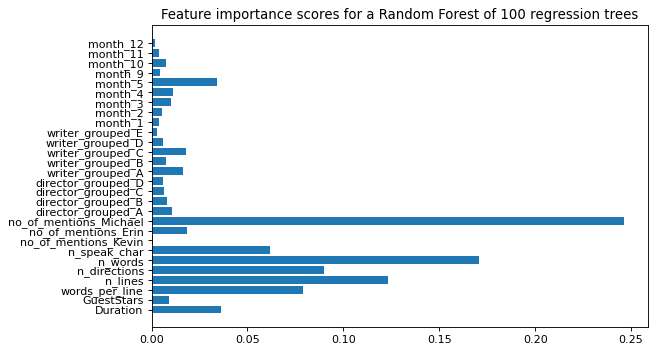

In [80]:
X = d.drop(['imdb_rating',"total_votes","Viewership"], axis=1)
y = d.imdb_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating an StandardScaler object
std_slc = StandardScaler()

# Creating a DecisionTreeRegressor object
ran_forest = RandomForestRegressor(n_estimators=100)

# The pipeline standardises the data, then trains the decision tree regressor model.
pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('ran_forest', ran_forest)])

# Creating lists of parameters to experiment with GridSearchCV, then inserting these into a dictionary
max_depth = list(range(10,21,1))

parameters = dict(ran_forest__max_depth=max_depth)

# KFold cross-validation specifications
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Creating a GridSearchCV object, using negative mean squared error as the metric
grid_search = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=kf)

# Run the grid_search object
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best criterion:', grid_search.best_estimator_.get_params()['ran_forest__criterion'])
print("best score: ", grid_search.best_score_)

# plot feature importance
importance = grid_search.best_estimator_.named_steps['ran_forest'].feature_importances_

plt.barh(X.columns, importance)
plt.title('Feature importance scores for a Random Forest of 100 regression trees')
plt.show()

### Decision Tree Regressor

While exploratory analysis revealed that `total_votes` and `viewership` are significantly related to `imdb_rating`, we decided not to us these as predictor variables, since they are not under the producers' control and hence we cannot make recommendations regarding these variables. These columns were therefore dropped from our dataset. The samples were then split into train and test sets. For the cross-validation, we only utilised the training set to prevent overfitting.

In [81]:
# drop columns that are not required, split samples into train and test sets
X = d.drop(['imdb_rating',"total_votes","Viewership"], axis=1)
y = d.imdb_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Before training the decision tree model, the data were standardised to ensure that variables are of similar orders of magnitudes, so as to maximise the performance of the model. 

Through cross-validation, we explored the effects of varying `max_depth` and `ccp_alpha`, which respectively control the maximum depth of the tree and the cost-complexity pruning of the tree to control the size of the tree and prevent overfitting. We started with a large, deep tree and pruned it according to cost-complexity.

A standard five-fold cross validation approach was employed. The resulting optimised hyperparamters were then outputted from the model, as shown in the output of the cell below.

In [82]:
# Creating an StandardScaler object
std_scaler = StandardScaler()

# Creating a DecisionTreeRegressor object
dec_tree = tree.DecisionTreeRegressor()

# The pipeline standardises the data, then trains the decision tree regressor model.
pipe = Pipeline(steps=[('std_scaler', std_scaler),
                       ('dec_tree', dec_tree)])

# Creating lists of parameters to experiment with GridSearchCV, then inserting these into a dictionary
criterion = ['mse']
max_depth = list(range(10,31,1))
ccp_alpha = list(np.arange(0,0.05,0.005))

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth, 
                  dec_tree__ccp_alpha=ccp_alpha)

# KFold cross-validation specifications
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Creating a GridSearchCV object, using negative mean squared error as the metric
grid_search = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=kf)

# Run the grid_search object
grid_search.fit(X_train, y_train)

# Print the best parameters
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best index:  81
best param:  {'dec_tree__ccp_alpha': 0.015, 'dec_tree__criterion': 'mse', 'dec_tree__max_depth': 28}
best score:  -0.24534650025370372


A significant advantage of decision tree models over other models lies in its simple interpretation. In the diagram below, the resulting decision tree is visualised so that its decision-making process could be investigated.

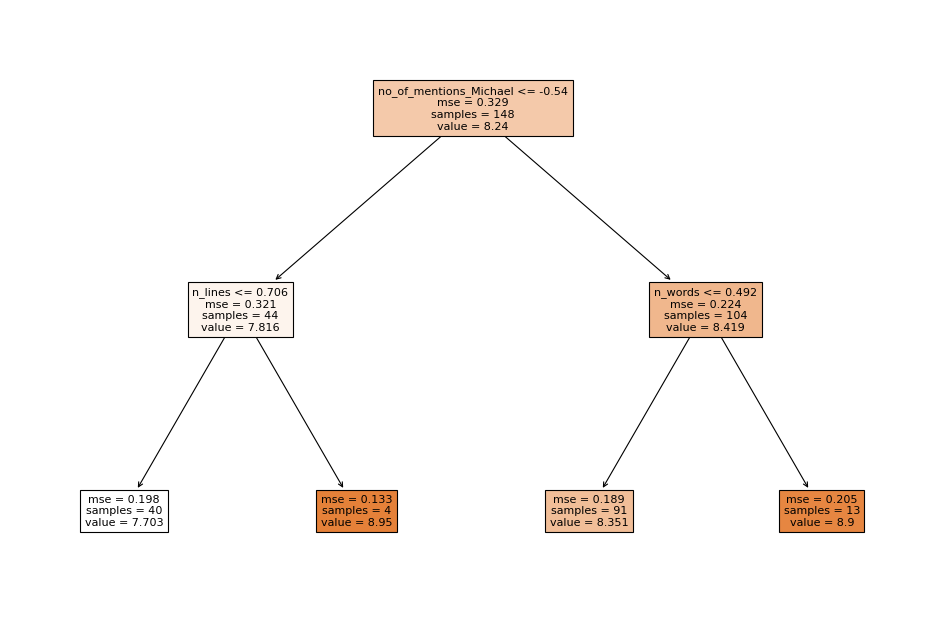

In [83]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(grid_search.best_estimator_.named_steps['dec_tree'], 
                   feature_names=X.columns,
                   filled=True, 
                   max_depth=5,
                   fontsize=10)

To inspect the accuracy of the model's predictions, we plotted predicted values against actual imdb ratings. Promisingly, the predicted values do generally increase for higher actual values. However, since the optimised decision tree is only two layers deep, the predicted values inevitably appear discrete due to the few number of splits in the tree. Nevertheless, this was found to be the optimal model by GridSearchCV after pruning. 

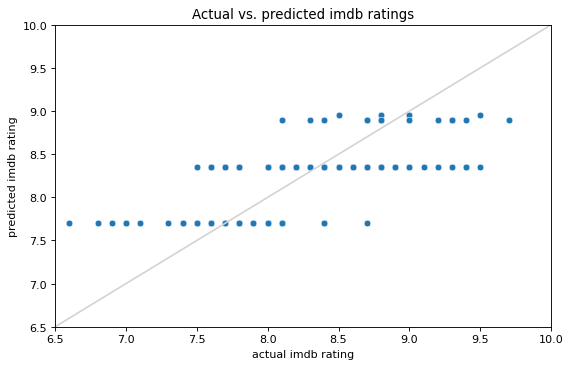

In [84]:
# plot actual vs. predicted imdb ratings
sns.scatterplot(x=y_train, y=grid_search.best_estimator_.predict(X_train));
plt.xlabel('actual imdb rating');
plt.ylabel('predicted imdb rating');
plt.xlim([6.5,10]);
plt.ylim([6.5,10]);
plt.title('Actual vs. predicted imdb ratings');

# plot diagonal line
x_diag = np.linspace(6.5,10,100)
y_diag = x_diag
plt.plot(x_diag, y_diag, color='lightgrey')
plt.show();

The residuals of the model are plotted against actual imdb values below to inspect whether our model is able to capture trends in the data. Promisingly, the residuals show no observable trends.

In [85]:
from scipy import stats

# Obtain regression slope and intercept
slope, intercept, rv, pv, se = stats.linregress(y_train, y_pred)

# Calculate residuals
resid = y_pred - slope * y_train - intercept

# Residual plot: fit regression line
sns.regplot(x=y_train, y=resid, ci=False, fit_reg=True); 
plt.ylabel('residuals');

NameError: name 'y_pred' is not defined

The root mean squared error for the test set was then computed to show the performance of the optimised model. The root mean squared error is worse than that from cross-validation, indicating that there was potential underfitting or overfitting despite having optimised the hyperparameters. 

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, grid_search.predict(X_test), squared=False)

#### Bootstrap
Bootstrapping let's us estimate not only the generalization error but also a confidence interval on that prediction error. Here we observe that the 95% confidence interval is very narrow at 0.01 compared to an RMSE of 0.245.

In [ ]:
from sklearn import utils
import statistics
import numpy as np, scipy.stats as st

In [ ]:
# Initializes a dataframe to take the bootstrap samples from
X_boot = X_train
X_boot.loc[:,"imdb_rating"] = y_train
X_boot

In [ ]:
# Stores the bootstrap samples
boots = []

# Resamples the data with replacements
i = 1
while i <= 100:
    boots.append(utils.resample(X_boot, replace=True, n_samples=len(X_train), random_state=i, stratify=None))
    i += 1

In [ ]:
# Stores the RMSE for each bootstrap sample
boot_rmse = []

# Obtains the RMSE for each bootstrap sample 
# by predicting using our model 
i = 0
while i < len(boots):
    boot_rmse.append(mean_squared_error(boots[i].imdb_rating, grid_search.predict(boots[i].drop("imdb_rating", axis = 1)), squared=False))
    i += 1

In [ ]:
# Obtains the 95% confident interval
conf_int = st.t.interval(0.95, len(boot_rmse)-1, loc=np.mean(boot_rmse), scale=st.sem(boot_rmse))

print("The 95% confidence interval is:", round(conf_int[1]-conf_int[0],3))

## 4. Discussion & Conclusions


Ultimately, we selected a regression tree model because it provides the best balance between high prediction accuracy and interpretability. Specifically, our final regression tree model is quite shallow at only two layers deep. This was obtained by initially developing a large tree before pruning it using the cost complexity criterion. Using this search over a large grid of possible parameter combinations, we obtain an optimal tree with an average 5-fold cross-validation RMSE of 0.245. This means that given information about a novel episode our model's prediction is on average within 0.245 rating points of the actual value. This is superior to all but the RandomForest model we tried which, however, suffers from poor interpretability. Bootstrapping the model by drawing randomly with replacement from the original tranining data, we see that the standard deviation of the RMSE over 100 bootstrapped samples is merely 0.01, indicating that value is reliable.  

Putting this prediction error into context, we observe that it adds value beyond the naive approach of predicting the mean rating on every episode (which produces an RMSE of 0.63). This shows that our model makes good use of the available data. When questioning why our model does not perform even better we should note several things: First, the episode ratings are fairly consistent, with a standard deviation of merely 0.59 around the mean which makes the mean actually a reasonable, yet useless estimator. Second, it is noteable that our model obtains this improvement while focussing on merely three pieces of data: the number of times Michael is mentioned in the episode's description, the number of words and the number of lines spoken in that episode. Third, we should consider the complexity of human thought and behaviour. Breaking down the popularity of an episode and people's inclination to rate it on a website is simply not a trivial task. We are therefore not surprised that this limited data set does not result in even better predictions. Since the content of an episode, i.e. the main character(s) are deemed most impactful by the model, a useful extension may be to consider sentiment or theme analysis to gain further insight into which content drives good ratings. 

A slightly puzzling result is given by RMSE on the test data which at 0.417 is significantly worse than the cross-validation RMSE. We would expect that the cross-validation RMSE is a representative estimate of the generalization error and we have no ready explanation for this large discrepancy. We checked whether the random train-test split perhaps resulted in unfortunate partitions, howewer this does not explain the discrepancy. We decided to be transparent about the result but not attach too much weight to it. We believe our methods are valid and adjusting our model based on unsatisfactory test results would violate the golden rule of machine learning to never train on your test data. 

Our regression tree allows us to make several recommendations. Specifically, the number of times Michael is mentioned in the episode description is important. We understand this a as proxy for the focus of the episode, and generally, focussing more on Michael is adviseable. Notably, however, there are a handful cases where Michael was incidental to the episode but the rating was still favourable as long as the episode had particularly many lines. Since this sample is quite small it is unclear how reliable this finding is. Therefore, we recommend designing an episode for the second best region on the right-hand branch of the tree. Specifically, Michael should be central to an episode and that episode should contain a high number of words. To be precise our model predicts a mean rating of 8.9, when 3447 words (corresponding to 0.492 standard deviations above the mean) are spoken and Michael is the focus of the episode. This corresponds to a rating within the top 12%.

A comment is warranted on the related characteristics of number of words, lines, directions and duration of an episode: Generally, longer episodes tend to be more popular than shorter ones, however, according to our model this appears to be best explained by the number of words and the number of lines rather than the actual length. It may therefore be advisable to have episodes with more dialogue rather than stretching out an episode for the sake of duration itself. This leads to another interesting conclusion, in that several characteristics did not emerge significant to the rating: For instance, we found no evidence that certain writers or directors wrote superior episodes. Neither did we find support for an effect Guest Stars may have. This suggests that the producers may wish to refrain from hiring expensive writers, directors and guests as they do not seems to contribute to the popularity of an episode.    

We believe that this analysis and the recommendations made above can help NBC Universal Studios produce a very popular reunion episode. 

## 5. Convert Document

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to markdown project1.ipynb